In [1]:
import os
import glob
from scipy.stats import mode
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import StratifiedShuffleSplit


In [2]:
# Hyperparameters
SEQ_LEN = 90
STEP_SIZE = 45
NUM_KEYPOINTS = 17
INPUT_DIM = 6
HIDDEN_DIM = 64
NUM_CLASSES = 9
EPOCHS = 50
BATCH_SIZE = 16
LEARNING_RATE = 0.0001
PATIENCE = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# COCO keypoint graph edges
COCO_EDGES = [(0, 1), (0, 2),         # Nose to eyes
              (1, 3), (2, 4),         # Eyes to ears
              (0, 5), (0, 6),         # Nose to shoulders
            #   (5, 6),                 # Shoulder connection
              (5, 7), (7, 9),         # Left arm
              (6, 8), (8, 10),        # Right arm
              (5, 11), (6, 12),       # Shoulders to hips
              (11, 12),               # Hip connection
              (11, 13), (13, 15),     # Left leg
              (12, 14), (14, 16)      # Right leg
]

adj = torch.eye(NUM_KEYPOINTS)
for i, j in COCO_EDGES:
    adj[i, j] = 1
    adj[j, i] = 1

In [3]:
# Label mapping 
LABELS = ['Attacking',
 'Biting',
 'Eating snacks',
 'Head banging',
 'Sitting quietly',
 'Throwing things',
 'Using phone',
 'Walking',
 'label_nan']
label_map = {label: idx for idx, label in enumerate(LABELS)}
label_map

{'Attacking': 0,
 'Biting': 1,
 'Eating snacks': 2,
 'Head banging': 3,
 'Sitting quietly': 4,
 'Throwing things': 5,
 'Using phone': 6,
 'Walking': 7,
 'label_nan': 8}

In [4]:
def calculate_joint_angle(p1, p2, p3):
    """Calculates the angle (in degrees) at vertex p2."""
    vec1 = p1 - p2
    vec2 = p3 - p2
    angle = np.degrees(np.arctan2(vec2[:, 1], vec2[:, 0]) - np.arctan2(vec1[:, 1], vec1[:, 0]))
    angle = np.abs(angle % 360)
    # Ensure the angle is the smaller one (<= 180)
    mask = angle > 180
    angle[mask] = 360 - angle[mask]
    return angle

In [5]:
def extract_features(df):

    coord_cols = [col for col in df.columns if col.endswith('_x') or col.endswith('_y')]
    parts = sorted(set(c.rsplit('_', 1)[0] for c in coord_cols))

    # GET VELOCITY AND ACCELERATION
    vel = {}
    acc = {}
    for part in parts:
        x = df[f"{part}_x"]
        y = df[f"{part}_y"]
        dx = x.diff()
        dy = y.diff()
        speed = np.sqrt(dx**2 + dy**2)
        vel[f"{part}_speed"] = speed

        ddx = dx.diff()
        ddy = dy.diff()
        accel = np.sqrt(ddx**2 + ddy**2)
        acc[f"{part}_accel"] = accel
        
    vel_df = pd.DataFrame(vel)
    acc_df = pd.DataFrame(acc)
    vel_df = vel_df.fillna(0)
    acc_df = acc_df.fillna(0)

    # GET DISTANCE 
    dist = {}
    for i in range(len(parts)):
        for j in range(i + 1, len(parts)):
            p1, p2 = parts[i], parts[j]
            dx = df[f"{p1}_x"] - df[f"{p2}_x"]
            dy = df[f"{p1}_y"] - df[f"{p2}_y"]
            dist[f"dist_{p1}_{p2}"] = np.sqrt(dx**2 + dy**2)
    
    dist_df = pd.DataFrame(dist)

 
    dist_useful = ['dist_left_ankle_left_hip', 'dist_left_ear_left_shoulder', 'dist_left_elbow_left_knee', 'dist_left_eye_left_wrist',
                'dist_left_hip_left_wrist', 'dist_left_knee_left_wrist', 'dist_left_shoulder_left_wrist', 'dist_left_wrist_nose',
                'dist_nose_right_wrist', 'dist_right_ankle_right_hip', 'dist_right_ear_right_shoulder', 'dist_right_elbow_right_knee',
                'dist_right_eye_right_wrist', 'dist_right_hip_right_wrist', 'dist_right_knee_right_wrist', 
                'dist_right_shoulder_right_wrist', 'dist_right_ankle_right_wrist']
    dist_df = dist_df[dist_useful]

    # GET ANGLES
    # Basic Joint Angles
    angle_definitions = {
        'left_ankle': [],
      'left_ear':['nose', 'left_ear', 'left_shoulder'],
        'left_elbow': ['left_shoulder', 'left_elbow', 'left_wrist'],
        'left_eye': ['left_ear', 'left_eye', 'left_wrist'],
          'left_hip': ['left_shoulder', 'left_hip', 'left_knee'],
          'left_knee': ['left_hip', 'left_knee', 'left_ankle'],
        'left_shoulder': ['left_elbow', 'left_shoulder', 'left_hip'],
          'left_wrist': [],
          'nose': ['left_shoulder',  'nose', 'right_shoulder'],
          'right_ankle': [],
          'right_ear': ['nose', 'right_ear', 'right_shoulder'],
        'right_elbow': ['right_shoulder', 'right_elbow', 'right_wrist'],
        'right_eye': ['right_ear', 'right_eye', 'right_wrist'],
        'right_hip': ['right_shoulder', 'right_hip', 'right_knee'],   
        'right_knee': ['right_hip', 'right_knee', 'right_ankle'],
        'right_shoulder': ['right_elbow', 'right_shoulder', 'right_hip'],
        'right_wrist': []
    }
    angle_df = {}
    for name, joints in angle_definitions.items():
        if len(joints) == 3:
            p1 = df[[f'{joints[0]}_x', f'{joints[0]}_y']].values
            p2 = df[[f'{joints[1]}_x', f'{joints[1]}_y']].values
            p3 = df[[f'{joints[2]}_x', f'{joints[2]}_y']].values
            angle_df[f'{name}_angle'] = calculate_joint_angle(p1, p2, p3)
        else:
            angle_df[f'{name}_angle'] = 0.0

    angle_df = pd.DataFrame(angle_df)

    extracted_features = pd.concat([vel_df, acc_df, dist_df, angle_df], axis=1)
  
    return extracted_features
    

In [ ]:
# Dataset class
class KeypointDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels 

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return torch.tensor(self.sequences[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)

# GCN layer
class GCNLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x, adj):
        support = self.linear(x)
        out = torch.matmul(adj, support)
        return out
    
class GCN_LSTM_Model(nn.Module):
    def __init__(self):
        super(GCN_LSTM_Model, self).__init__()
        self.gcn1 = GCNLayer(INPUT_DIM, 32)
        self.gcn2 = GCNLayer(32, 64)
        self.gcn3 = GCNLayer(64, 128)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

        self.lstm1 = nn.LSTM(input_size=128 * NUM_KEYPOINTS, hidden_size=128, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=128, hidden_size=64, batch_first=True)
        self.lstm3 = nn.LSTM(input_size=64, hidden_size=32, batch_first=True)

        self.ln1 = nn.LayerNorm(128)
        self.ln2 = nn.LayerNorm(64)
        self.ln3 = nn.LayerNorm(32)

        self.fc1 = nn.Linear(32, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, NUM_CLASSES)

        self.final_dropout = nn.Dropout(0.3)

    def forward(self, x):
        B, T, N, D = x.shape
        x = x.view(B * T, N, D)
        
        x = self.relu(self.gcn1(x, adj.to(x.device)))
        x = self.dropout(x)

        x = self.relu(self.gcn2(x, adj.to(x.device)))
        x = self.dropout(x)

        x = self.relu(self.gcn3(x, adj.to(x.device)))
        x = self.dropout(x)        

        x = x.view(B, T, -1)     #flatten gcn output for lstm

        x, _ = self.lstm1(x)
        x = self.ln1(x)

        x, _ = self.lstm2(x)
        x = self.ln2(x)

        x, _ = self.lstm3(x)
        x = self.ln3(x)

        x = x[:, -1, :]     #use last time step
        
        x = self.final_dropout(self.relu(self.fc1(x)))
        x = self.final_dropout(self.relu(self.fc2(x)))
        out = self.fc3(x)

        return out


In [7]:

# # Prepare sequences from a single CSV
def prepare_sequences(df):
    df = df[df['label'].isin(LABELS)]
    keypoint_df = df.drop(columns=['frame_id', 'label'])
    kp_data = keypoint_df.values
    labels = df['label'].map(label_map).values

    sequences, seq_labels = [], []
    for i in range(0, len(df) - SEQ_LEN + 1, STEP_SIZE):
        seq = kp_data[i:i+SEQ_LEN]
        label_window = labels[i : i + SEQ_LEN]
        label = int(mode(label_window, keepdims=True)[0][0])
        seq = seq.reshape((SEQ_LEN, NUM_KEYPOINTS, INPUT_DIM))
        sequences.append(seq)
        seq_labels.append(label)

    return np.array(sequences), np.array(seq_labels)



In [8]:

# Load all subjects
def load_all_subjects(data_dir):
    files = glob.glob(os.path.join(data_dir, "*.csv"))
    all_dfs = []
    for file in files:
        df = pd.read_csv(file)

        #  PREPROCESSING
        df['label'] = df['label'].fillna('label_nan')
        df['label'] = df['label'].replace('Throwing', 'Throwing things')

        # remove negatives
        df = df[(df.select_dtypes(include=[np.number]) >= 0).all(axis=1)]

        # remove anomalies using z-score
        coords_columns = [col for col in df.columns if col.endswith('_x') or col.endswith('_y')]
        z_scores = ((df[coords_columns] - df[coords_columns].mean()) / df[coords_columns].std()).abs()
        outliers = (z_scores > 4).any(axis=1)   
        outlier_rows = df[outliers]
        outlier_indices = outlier_rows.index.tolist()   # Get rows index where outliers is True
        df_no_anomalies = df.drop(index=outlier_indices)
        df_no_anomalies.reset_index(inplace=True, drop=True) 

        # extract features and remove anomalies
        extracted_features = extract_features(df_no_anomalies)

        z_features = ((extracted_features.select_dtypes(include=[np.number]) -
               extracted_features.select_dtypes(include=[np.number]).mean()) /
               extracted_features.select_dtypes(include=[np.number]).std()).abs()
        anomalies = (z_features > 4).any(axis=1)
        anomalies_rows = extracted_features[anomalies]
        anomalies_index = anomalies_rows.index.tolist()
        extracted_features_no_anomalies = extracted_features.drop(index = anomalies_index)
        
        df_no_anomalies = df_no_anomalies.drop(index = anomalies_index)

        # reset index
        df_no_anomalies.reset_index(inplace=True, drop=True)
        extracted_features_no_anomalies.reset_index(inplace=True, drop=True)

        # merge all features
        final_df = pd.concat([df_no_anomalies.drop(columns=['label']), extracted_features_no_anomalies, df_no_anomalies[['label']]], axis=1)


        # scaling
        feature_columns = final_df.columns.difference(['frame_id', 'label'])
        ss = StandardScaler()
        sub_scaled = final_df.copy()
        sub_scaled[feature_columns] = ss.fit_transform(final_df[feature_columns])   
        
        # order = [0,1,2,43,60,77,
        #         3,4,38,55,72,
        #         5,6,47,64,81,
        #         7,8,36,53,70,
        #         9,10,45,62,79,
        #         11,12,41,58,75,
        #         13,14,50,67,84,
        #         15,16,37,54,71,
        #         17,18,46,63,80,
        #         19,20,42,59,76,
        #         21,22,51,68,85,
        #         23,24,39,56,73,
        #         25,26,48,65,82,
        #         27,28,40,57,74,
        #         29,30,49,66,83,
        #         31,32,35,52,69,
        #         33,34,44,61,78,86]
        order = [0,1,2,43,60,77,94,
        3,4,38,55,72,89,
        5,6,47,64,81,98,
        7,8,36,53,70,87,
        9,10,45,62,79,96,
        11,12,41,58,75,92,
        13,14,50,67,84,101,
        15,16,37,54,71,88,
        17,18,46,63,80,97,
        19,20,42,59,76,93,
        21,22,51,68,85,102,
        23,24,39,56,73,90,
        25,26,48,65,82,99,
        27,28,40,57,74,91,
        29,30,49,66,83,100,
        31,32,35,52,69,86,
        33,34,44,61,78,95,103]
        sub_scaled_ordered = sub_scaled.iloc[:, order]

        # all_dfs.append(sub_scaled)
        sequences, labels = prepare_sequences(sub_scaled_ordered)
        if len(sequences) > 0:
            all_dfs.append((sequences, labels, os.path.basename(file)))
        # final_df = pd.concat(all_dfs, ignore_index=True)
    return all_dfs

In [9]:
#Main
dir = r'D:\pr_env\py_env\Scripts\keypointlabel'
subjects_data = load_all_subjects(dir)  
# subjects_data

Epoch 1: Train Loss=2.0397, Train Acc=0.2933
 Val Loss=1.8193, Val Acc=0.3755
Epoch 2: Train Loss=1.7034, Train Acc=0.4064
 Val Loss=1.5155, Val Acc=0.6282
Epoch 3: Train Loss=1.4010, Train Acc=0.5627
 Val Loss=1.0890, Val Acc=0.7419
Epoch 4: Train Loss=1.0765, Train Acc=0.7039
 Val Loss=0.7681, Val Acc=0.8574
Epoch 5: Train Loss=0.8333, Train Acc=0.8041
 Val Loss=0.6500, Val Acc=0.8538
Epoch 6: Train Loss=0.6635, Train Acc=0.8562
 Val Loss=0.5812, Val Acc=0.8700
Epoch 7: Train Loss=0.5955, Train Acc=0.8692
 Val Loss=0.5037, Val Acc=0.9061
Epoch 8: Train Loss=0.5103, Train Acc=0.8897
 Val Loss=0.4311, Val Acc=0.8827
Epoch 9: Train Loss=0.4624, Train Acc=0.9096
 Val Loss=0.4117, Val Acc=0.9134
Epoch 10: Train Loss=0.4416, Train Acc=0.9120
 Val Loss=0.4018, Val Acc=0.9134
Epoch 11: Train Loss=0.4659, Train Acc=0.8982
 Val Loss=0.3376, Val Acc=0.9314
Epoch 12: Train Loss=0.3887, Train Acc=0.9192
 Val Loss=0.3468, Val Acc=0.9260
Epoch 13: Train Loss=0.3735, Train Acc=0.9253
 Val Loss=0.285

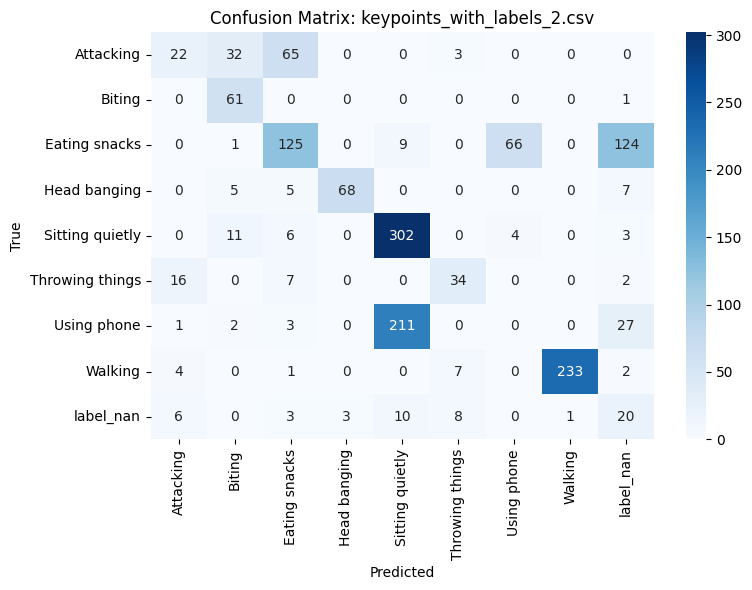

In [10]:
test_seq, test_lbl, test_name = subjects_data[1]

# Combine training data from other subjects
train_seq = np.concatenate([s for j, (s, _, _) in enumerate(subjects_data) if j != 1])
train_lbl = np.concatenate([l for j, (_, l, _) in enumerate(subjects_data) if j != 1])

# Stratified Train/Validation Split
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
train_idx, val_idx = next(splitter.split(train_seq, train_lbl))
X_train, y_train = train_seq[train_idx], train_lbl[train_idx]
X_val, y_val = train_seq[val_idx], train_lbl[val_idx]

train_loader = DataLoader(KeypointDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(KeypointDataset(X_val, y_val), batch_size=BATCH_SIZE)
test_loader = DataLoader(KeypointDataset(test_seq, test_lbl), batch_size=BATCH_SIZE)

model = GCN_LSTM_Model().to(device)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=0.1e-5)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)

best_val_loss = float('inf')
patience_counter = 0
best_model_state = None

for epoch in range(EPOCHS):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == batch_y).sum().item()
        total += batch_y.size(0)

    train_acc = correct / total
    print(f"Epoch {epoch+1}: Train Loss={total_loss/len(train_loader):.4f}, Train Acc={train_acc:.4f}")

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == batch_y).sum().item()
            val_total += batch_y.size(0)

    val_loss /= len(val_loader)
    val_acc = val_correct / val_total
    print(f" Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")
    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print("Early stopping triggered based on val_loss.")
            break

# Load best model
model.load_state_dict(best_model_state)

# # Final Test Evaluation
print('------------------TESTING ON SUBJECT 2-----------------')
model.eval()
all_preds, all_true = [], []
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.to(device)
        outputs = model(batch_x)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_true.extend(batch_y.numpy())

f1 = f1_score(all_true, all_preds, average='macro')
acc = accuracy_score(all_true, all_preds)
print(f"Test Accuracy = {acc:.4f}, Test Macro F1 = {f1:.4f}")

# Confusion matrix
cm = confusion_matrix(all_true, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=LABELS, yticklabels=LABELS)
plt.title(f'Confusion Matrix: {test_name}')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()


In [11]:
from sklearn.metrics import classification_report
# Classification report
report = classification_report(all_true, all_preds, target_names=LABELS)
print(report)

                 precision    recall  f1-score   support

      Attacking       0.45      0.18      0.26       122
         Biting       0.54      0.98      0.70        62
  Eating snacks       0.58      0.38      0.46       325
   Head banging       0.96      0.80      0.87        85
Sitting quietly       0.57      0.93      0.70       326
Throwing things       0.65      0.58      0.61        59
    Using phone       0.00      0.00      0.00       244
        Walking       1.00      0.94      0.97       247
      label_nan       0.11      0.39      0.17        51

       accuracy                           0.57      1521
      macro avg       0.54      0.58      0.53      1521
   weighted avg       0.55      0.57      0.53      1521



In [12]:
# test data loading
test_df = pd.read_csv(r'D:\pr_env\py_env\Scripts\keypoint_test_data\test data_keypoint.csv')
# test_df

In [13]:
extracted_test_features = extract_features(test_df)
# extracted_test_features

In [14]:
final_test_df = pd.concat([test_df, extracted_test_features], axis=1)
final_test_df

,frame_id,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,...,left_wrist_angle,nose_angle,right_ankle_angle,right_ear_angle,right_elbow_angle,right_eye_angle,right_hip_angle,right_knee_angle,right_shoulder_angle,right_wrist_angle
0,0,630.5,420.500,638.5,413.000,621.5,413.500,649.5,419.250,610.0,...,0.0,80.518798,0.0,107.496124,146.110160,62.427979,119.580298,48.671290,12.095984,0.0
1,1,629.5,421.750,637.5,414.000,620.5,414.500,648.5,420.250,609.0,...,0.0,81.757645,0.0,109.414962,145.260553,59.115705,118.841319,48.250829,12.452536,0.0
2,2,629.0,423.250,637.0,415.500,620.0,416.000,648.0,421.000,608.0,...,0.0,82.976878,0.0,107.470645,145.146296,62.156284,118.029065,48.949997,12.937690,0.0
3,3,628.5,424.250,636.5,416.500,619.5,417.250,647.0,421.500,607.0,...,0.0,83.469458,0.0,106.343889,146.309932,65.117102,117.510638,49.695254,12.668596,0.0
4,4,628.5,425.750,636.0,417.750,619.0,418.750,646.0,422.500,606.5,...,0.0,85.101421,0.0,106.812867,147.232980,64.570808,116.328728,50.543428,12.370071,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117916,117916,571.5,215.750,580.5,205.625,560.5,207.250,594.0,208.625,546.5,...,0.0,71.855616,0.0,94.790205,167.234395,62.555284,176.289151,179.445461,16.747331,0.0
117917,117917,572.0,215.625,581.5,205.375,561.0,207.000,595.0,209.000,547.0,...,0.0,71.746299,0.0,95.376091,168.611129,60.924062,175.765420,179.681385,17.002853,0.0
117918,117918,573.0,215.000,582.0,205.125,562.0,206.625,596.0,209.250,548.0,...,0.0,71.236189,0.0,97.798136,169.508702,58.490806,175.764029,179.987051,16.962899,0.0
117919,117919,574.0,214.750,583.0,204.875,563.0,206.375,597.0,209.000,549.0,...,0.0,71.207717,0.0,97.843341,170.401992,58.311788,176.004538,179.973873,17.092621,0.0


In [15]:
feature_columns = final_test_df.columns.difference(['frame_id', 'label'])
ss = StandardScaler()
test_scaled = final_test_df.copy()
test_scaled[feature_columns] = ss.fit_transform(final_test_df[feature_columns])   

order = [0,1,2,43,60,77,94,
        3,4,38,55,72,89,
        5,6,47,64,81,98,
        7,8,36,53,70,87,
        9,10,45,62,79,96,
        11,12,41,58,75,92,
        13,14,50,67,84,101,
        15,16,37,54,71,88,
        17,18,46,63,80,97,
        19,20,42,59,76,93,
        21,22,51,68,85,102,
        23,24,39,56,73,90,
        25,26,48,65,82,99,
        27,28,40,57,74,91,
        29,30,49,66,83,100,
        31,32,35,52,69,86,
        33,34,44,61,78,95]
test_scaled_ordered = test_scaled.iloc[:, order]

In [16]:
test_scaled_ordered

,frame_id,nose_x,nose_y,nose_speed,nose_accel,dist_nose_right_wrist,nose_angle,left_eye_x,left_eye_y,left_eye_speed,...,left_ankle_speed,left_ankle_accel,dist_left_ankle_left_hip,left_ankle_angle,right_ankle_x,right_ankle_y,right_ankle_speed,right_ankle_accel,dist_right_ankle_right_hip,right_ankle_angle
0,0,-0.248519,0.736692,-0.638342,-0.605528,0.768024,-0.325633,-0.224225,0.747038,-0.637371,...,-0.464193,-0.446904,-1.082571,0.0,-0.101117,0.323853,-0.453786,-0.472857,-1.159910,0.0
1,1,-0.266107,0.746920,0.151244,-0.605528,0.756595,-0.299975,-0.241947,0.755201,0.065370,...,-0.297005,-0.446904,-1.089772,0.0,-0.092232,0.323853,-0.305773,-0.472857,-1.160955,0.0
2,2,-0.274902,0.759194,0.141556,-0.141575,0.726616,-0.274724,-0.250807,0.767444,0.148318,...,0.064503,0.011685,-1.067043,0.0,-0.092232,0.334676,-0.305773,-0.255641,-1.145784,0.0
3,3,-0.283696,0.767377,-0.086871,-0.190556,0.711609,-0.264522,-0.259668,0.775607,-0.081805,...,-0.227753,0.236720,-1.053765,0.0,-0.110002,0.334676,-0.157759,-0.129409,-1.143034,0.0
4,4,-0.283696,0.779652,0.101534,-0.018668,0.689147,-0.230723,-0.268529,0.785810,0.031619,...,-0.297005,-0.105092,-1.035733,0.0,-0.145542,0.356323,0.208151,-0.038425,-1.148748,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117916,117916,-1.286243,-0.938745,-0.141253,-0.190556,1.455320,-0.505056,-1.252065,-0.945640,-0.136591,...,0.008687,-0.014542,1.172591,0.0,-1.025147,0.129030,-0.305773,-0.255641,0.869413,0.0
117917,117917,-1.277448,-0.939767,-0.384126,-0.190556,1.482466,-0.507320,-1.234344,-0.947681,-0.125165,...,-0.297005,-0.105092,1.183436,0.0,-1.025147,0.129030,-0.453786,-0.319262,0.879585,0.0
117918,117918,-1.259860,-0.944882,-0.056677,-0.018668,1.513417,-0.517885,-1.225483,-0.949721,-0.359588,...,0.008687,-0.105092,1.197139,0.0,-1.025147,0.139853,-0.305773,-0.319262,0.882459,0.0
117919,117919,-1.242271,-0.946927,-0.129911,-0.294299,1.533830,-0.518474,-1.207762,-0.951762,-0.125165,...,0.037372,-0.105092,1.195958,0.0,-1.025147,0.129030,-0.305773,-0.165667,0.868888,0.0


In [17]:
# convert to  sequences
def prepare_test_sequences(df):
    keypoint_df = df.drop(columns=['frame_id'])
    kp_data = keypoint_df.values
    sequences = []
    for i in range(0, len(df) - SEQ_LEN + 1, STEP_SIZE):
        seq = kp_data[i:i+SEQ_LEN]
        seq = seq.reshape((SEQ_LEN, NUM_KEYPOINTS, INPUT_DIM))
        sequences.append(seq)

    return np.array(sequences)


In [18]:
test_sequences = prepare_test_sequences(test_scaled_ordered)

In [19]:
test_sequences.shape

(2619, 90, 17, 6)

In [20]:
# Dataset class
class TestDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences
        # self.labels = labels 

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return torch.tensor(self.sequences[idx], dtype=torch.float32)#, torch.tensor(self.labels[idx], dtype=torch.long)


In [21]:
test_loader = DataLoader(TestDataset(test_sequences), batch_size=BATCH_SIZE, shuffle = False)

In [22]:
import torch.nn.functional as F
from collections import defaultdict
from tqdm import tqdm

total_frames = len(test_df)

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)
model.eval()

frame_probs = defaultdict(list)
frame_preds = defaultdict(list)

for batch_idx, batch in enumerate(tqdm(test_loader, desc="Predicting")):
    batch = batch.to(device)

    with torch.no_grad():
        outputs = model(batch)
        probs = F.softmax(outputs, dim=1).cpu().numpy()
        preds = np.argmax(probs, axis=1)

    for i in range(len(batch)):
        seq_idx = batch_idx * BATCH_SIZE + i
        start_frame = seq_idx * STEP_SIZE
        end_frame = start_frame + SEQ_LEN

        for f in range(start_frame, end_frame):
            if f >= total_frames:
                continue
            frame_probs[f].append(probs[i])
            frame_preds[f].append(preds[i])


Predicting: 100%|██████████| 164/164 [00:19<00:00,  8.36it/s]


In [23]:
inv_label_map = {v: k for k, v in label_map.items()}

final_results = []
for frame in sorted(frame_probs.keys()):
    avg_prob = np.mean(frame_probs[frame], axis=0)
    pred_label = int(np.argmax(avg_prob))
    pred_prob = float(np.max(avg_prob))

    final_results.append({
        "frame_id": frame,
        "predicted_label": pred_label,
        "predicted_class_name": inv_label_map[pred_label],
        "predicted_probability": pred_prob
    })


In [24]:
df = pd.DataFrame(final_results)

In [25]:
df

,frame_id,predicted_label,predicted_class_name,predicted_probability
0,0,4,Sitting quietly,0.994609
1,1,4,Sitting quietly,0.994609
2,2,4,Sitting quietly,0.994609
3,3,4,Sitting quietly,0.994609
4,4,4,Sitting quietly,0.994609
...,...,...,...,...
117895,117895,8,label_nan,0.812043
117896,117896,8,label_nan,0.812043
117897,117897,8,label_nan,0.812043
117898,117898,8,label_nan,0.812043


In [ ]:

df.to_csv("frame_level_predictions3.csv", index=False)
# print("✅ Saved: frame_level_predictions.csv")
